# Nested Modelling

In [2]:
# Loading Dataset
import numpy as np
import pandas as pd
import imp # python's import helper
df = pd.read_csv("/Users/harshvardhan/Documents/UTK/Classes/Spring 2022/BZAN 557 671 Text Mining/Project/Complaints/complaints_processed.csv")
df
# Change Product Names to Integers for Faster Processing
df['product'].unique()
product_dict = {'credit_reporting': 0, 'debt_collection': 1, 'mortgages_and_loans': 2, 'credit_card': 3, 'retail_banking': 4}
df['product'].replace(product_dict, inplace=True)
df["product"].unique()

array([3, 4, 0, 2, 1])

(array([91178.,     0., 23147.,     0.,     0., 18990.,     0., 15564.,
            0., 13536.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

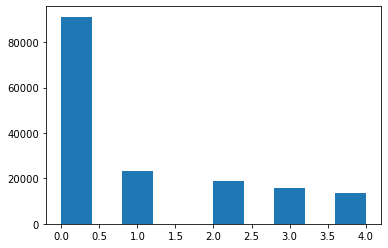

In [3]:
import matplotlib.pyplot as plt
plt.hist(df["product"])

In [4]:
from sklearn.model_selection import train_test_split
X = df["narrative"].values.astype("U").tolist()
y = df['product'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 0)

Before applying the models, I will create an additional `y0` which will have 0 for all {y = 0} (i.e. only the first and largest category) and 1 otherwise.

In [5]:
y0 = []

for i in range(len(y_train)):
    if(y_train[i] == 0):
        y0.append(0)
    else:
        y0.append(1)

(array([63801.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 49889.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

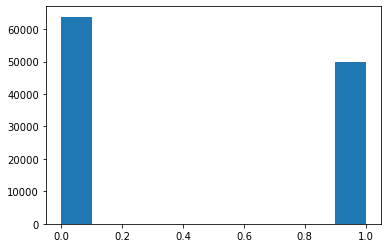

In [6]:
plt.hist(y0)

The second model will be trained only on four classes, i.e. minus the first class (0).

In [7]:
idx = [i for i in range(len(y_train)) if y_train[i]!=0]

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
vect_X_train = vectorizer.fit_transform(X_train)
feature_names =  vectorizer.get_feature_names()

In [9]:
vect_X_test = vectorizer.transform(X_test)

In [10]:
X_2 = vect_X_train[idx,:]
y_2 = [y_train[i] for i in idx]

(array([16181.,     0.,     0., 13283.,     0.,     0., 10912.,     0.,
            0.,  9513.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

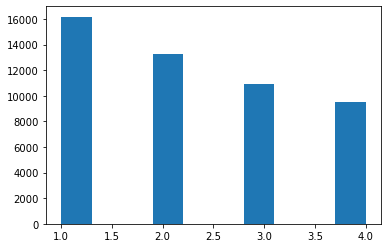

In [11]:
plt.hist(y_2)

# First Model
Where Y is `y0` and X is `vect_X_train`.

## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
rdmfst1 = RandomForestClassifier(max_depth=20)
rdmfst1.fit(vect_X_train, y0)

RandomForestClassifier(max_depth=20)

In [13]:
rdmfst1.score(vect_X_train, y0)

0.9101416131585891

### Hyper-parameter Tuning

Here are the current parameters.

In [14]:
rdmfst1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Some parameters that I want to try different values:
- n_estimators = number of trees in the foreset
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node

In [13]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [50, 100, 200, 500]

# Maximum number of levels in tree
max_depth = [10, 20, 50]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

random_grid

{'n_estimators': [50, 100, 200, 500],
 'max_depth': [10, 20, 50],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

I will use 3-fold CV and at each fold, I will search for 50 different combinations of the the grid. Since my Mac can support multicore computations, I will also use all cores. These things will likely improve my model.

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier()
# 108 = 3*3*3*4 ~ 10
rf_random = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=1, random_state=0, n_jobs = -1)
rf_random.fit(vect_X_train, y0)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=0, verbose=1)

In [16]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 50}

In [17]:
rf_random.best_score_

0.9146450934627911

There is only 1% accuracy gain even though the model is significantly more complex.

# Second Model
Now, let's train the second model with Y = `y_2` and X = `X_2`.

## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
rdmfst2 = RandomForestClassifier(max_depth=20)
rdmfst2.fit(X_2, y_2)
rdmfst2.score(X_2, y_2)

0.9004590190222294

### Hyper-parameter Tuning

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=1, random_state=0, n_jobs = -1)
rf_random.fit(X_2, y_2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=0, verbose=1)

In [20]:
rf_random.best_score_

0.8788910839881175

This is worse than the untuned model. Thus, I will stick with the original models.

In [16]:
# function to predict class
def predict_class(test_x):
    y1 = rdmfst1.predict(test_x)
    if(y1 != 0):
        y1 = rdmfst2.predict(test_x)
    
    return(y1[0])

In [17]:
y_ptrn = [] #predicted training nested
for i in range(vect_X_train.shape[0]):
    v = predict_class(vect_X_train[i])
    y_ptrn.append(v)

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_ptrn)

0.8763567596094644

In [19]:
y_pten = [] #predicted training nested
for i in range(vect_X_test.shape[0]):
    v = predict_class(vect_X_test[i])
    y_pten.append(v)

In [20]:
accuracy_score(y_test, y_pten)

0.836182657773217

### Confusion Matrix Plot

In [34]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_train, y_ptrn)

print(cf_matrix)

[[60717  1199  1029   698   158]
 [ 4868 10563   404   247    99]
 [ 1033   451 11510   137   152]
 [ 1012   578   257  8442   623]
 [  219   373   181   339  8401]]


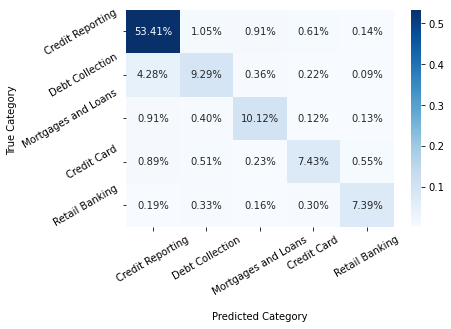

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

#ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('True Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Credit Reporting', 'Debt Collection', 'Mortgages and Loans', 'Credit Card', 'Retail Banking'], rotation = 30)
ax.yaxis.set_ticklabels(['Credit Reporting', 'Debt Collection', 'Mortgages and Loans', 'Credit Card', 'Retail Banking'], rotation = 30)

## Save fig
plt.savefig("/Users/harshvardhan/Documents/UTK/Classes/Spring 2022/BZAN 557 671 Text Mining/Project/Complaints/Plots/confusion_matrix_train.pdf", bbox_inches='tight')

## Display the visualization of the Confusion Matrix.
plt.show()


In [21]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pten)

print(cf_matrix)

[[25559   691   633   410    84]
 [ 2485  4005   272   154    50]
 [  574   250  4675   112    96]
 [  493   292   205  3201   461]
 [  105   175   144   296  3303]]


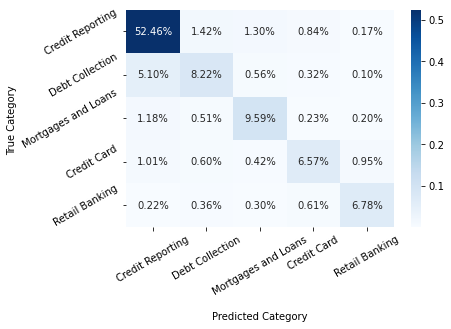

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

#ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('True Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Credit Reporting', 'Debt Collection', 'Mortgages and Loans', 'Credit Card', 'Retail Banking'], rotation = 30)
ax.yaxis.set_ticklabels(['Credit Reporting', 'Debt Collection', 'Mortgages and Loans', 'Credit Card', 'Retail Banking'], rotation = 30)

## Save fig
plt.savefig("/Users/harshvardhan/Documents/UTK/Classes/Spring 2022/BZAN 557 671 Text Mining/Project/Complaints/Plots/confusion_matrix_test.pdf", bbox_inches='tight')

## Display the visualization of the Confusion Matrix.
plt.show()
